In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from matplotlib import animation
from matplotlib.animation import PillowWriter
from scipy.optimize import root

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [10 , 10]

# Units

In [2]:
G_pu = 6.67430e-8       #cm^3*s/g
r_pu = 1.49597870707e13 #cm
m_pu = 1.989e33         #g

v_pu = np.sqrt(G_pu * m_pu / r_pu)
print("v_pu/v_iu = ", v_pu, "(cm/s)/iu")

v_pu/v_iu =  2978911.131907573 (cm/s)/iu


# Total Energy Check

In [3]:
data = pandas.read_csv('./twobody.in',
                        sep='\s+',
                        names=['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz'],
                        engine='python')

In [4]:
m1 = 1
m2 = 1/1000

pos1 = data.iloc[2].to_numpy()[1:4]
pos2 = data.iloc[3].to_numpy()[1:4]
r = pos2-pos1

v1 = data.iloc[2].to_numpy()[4:]
v2 = data.iloc[3].to_numpy()[4:]

E_grav = -m1*m2/(np.linalg.norm(r))
E_kin1 = 0.5*m1*(np.linalg.norm(v1))**2
E_kin2 = 0.5*m2*(np.linalg.norm(v2))**2
E_tot = E_grav + E_kin1 + E_kin2
print("E_tot = ", E_tot, "internal units")
#print("E_tot would be zero if v =", np.sqrt(2/np.linalg.norm(r)))

E_tot =  -0.0005 internal units


In [5]:
L = np.linalg.norm(m2*np.cross(r, v2))

def V_eff(x):
    return (L**2)/(2*m2*x**2) - m1*m2/x

# 1) Circular Orbit

In [6]:
data = pandas.read_csv('./twobody.out',
                        sep='\s+',
                        names=['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz'],
                        engine='python')

indices = []

for index, row in data.iterrows():
    if math.isnan(row[1])==False: 
        indices.append(index)

data = data[data.index.isin(indices)]

In [7]:
x = data[["x"]].to_numpy()
y = data[["y"]].to_numpy()
z = data[["z"]].to_numpy()
vx = data[["vx"]].to_numpy()
vy = data[["vy"]].to_numpy()
vz = data[["vz"]].to_numpy()

x1, y1, z1, x2, y2, z2, vx1, vy1, vz1, vx2, vy2, vz2 = np.array([[], [], [], [], [], [], [], [], [], [], [], []])

for i in range(len(x)):
    if (i%2==0): 
        x1 = np.append(x1, x[i])
        y1 = np.append(y1, y[i])
        z1 = np.append(z1, z[i])
        vx1 = np.append(vx1, vx[i])
        vy1 = np.append(vy1, vy[i])
        vz1 = np.append(vz1, vz[i])
    else:
        x2 = np.append(x2, x[i])
        y2 = np.append(y2, y[i])
        z2 = np.append(z2, z[i])
        vx2 = np.append(vx2, vx[i])
        vy2 = np.append(vy2, vy[i])
        vz2 = np.append(vz2, vz[i])

In [8]:
dist = np.linalg.norm([x2-x1, y2-y1, z2-z1], axis=0)
dist

array([0.9999998 , 0.99999955, 0.9999992 , ..., 0.99919967, 0.99920944,
       0.99921919])

### Plot

Text(0.5, 0, 'y')

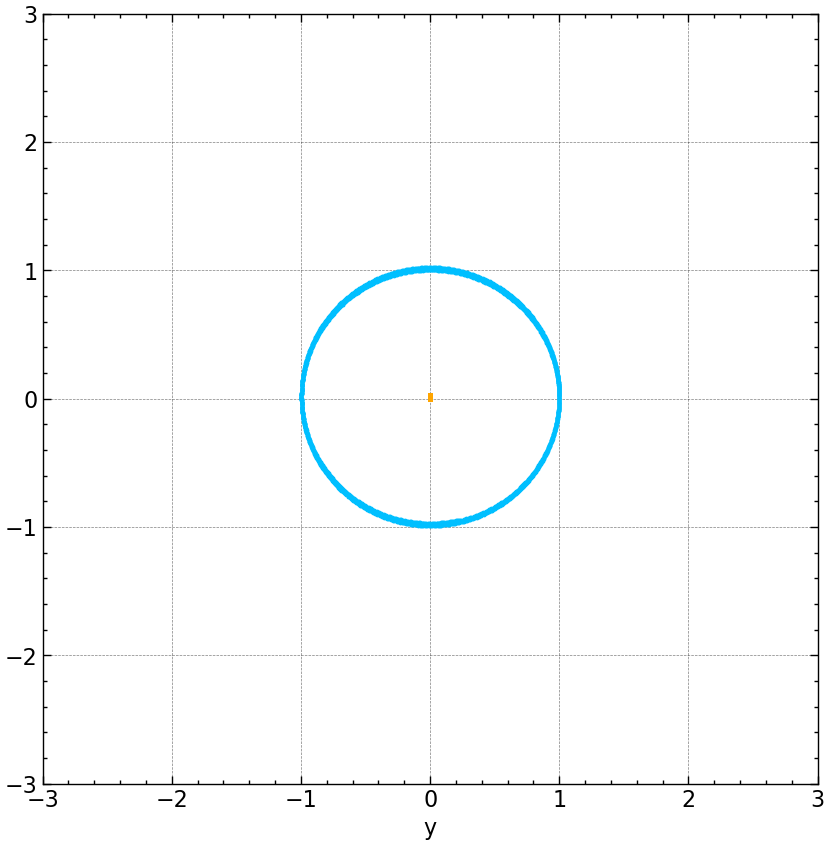

In [9]:
plt.scatter(x1, y1, marker='o', s=5, color='orange')
plt.scatter(x2, y2, marker='o', s=3, color='deepskyblue')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('x')
plt.xlabel('y')

### Animation

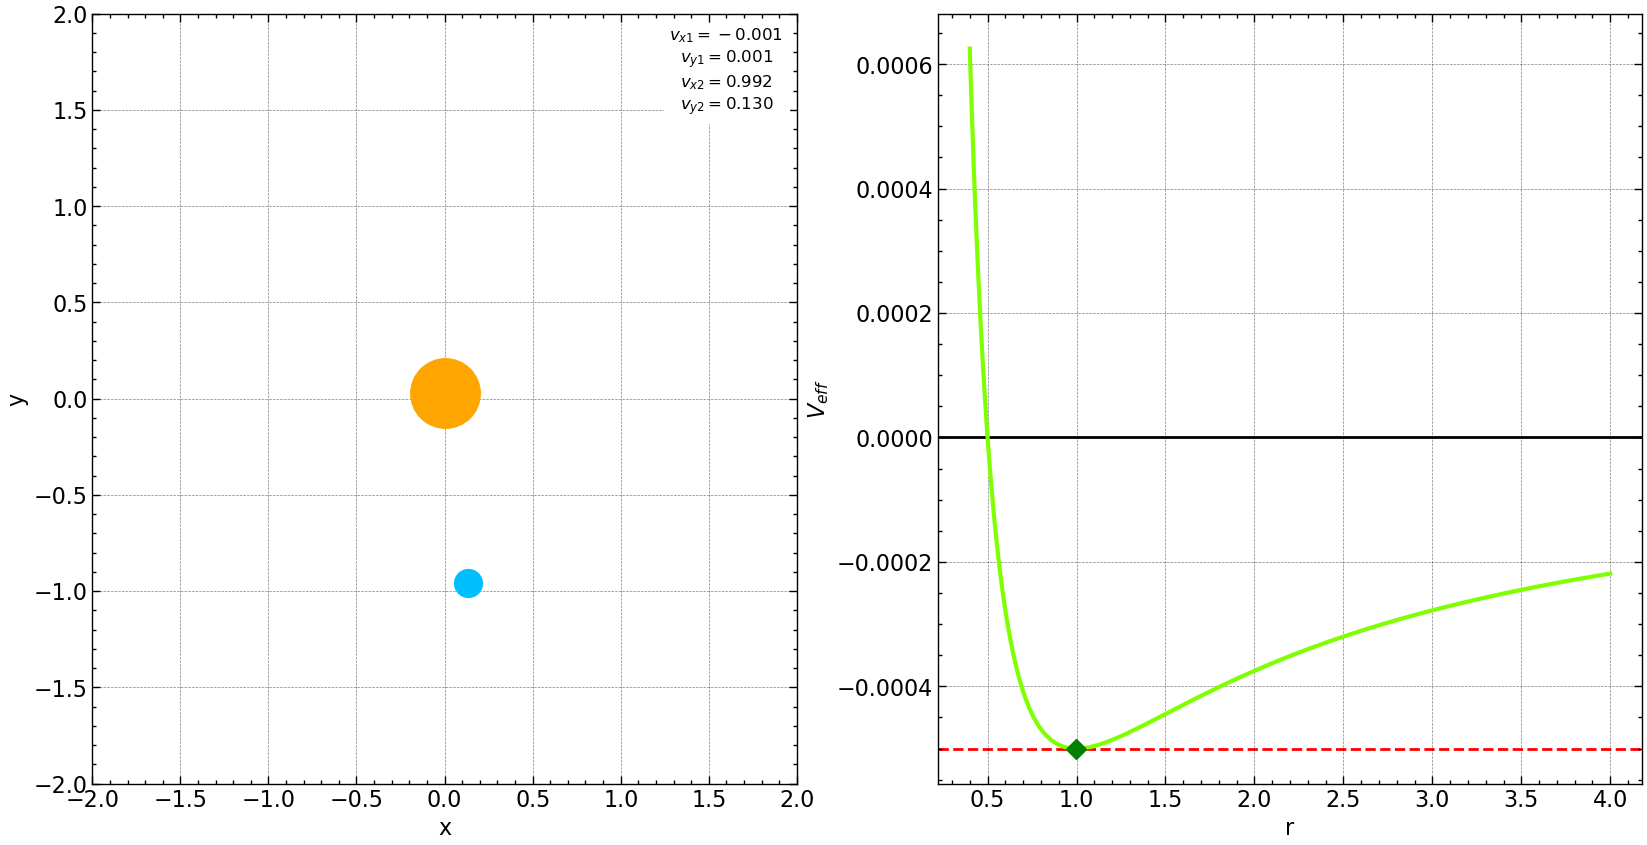

In [10]:
#fig = plt.Figure() #somehow faster than fig, ax = plt.subplots(1,1), but text doesn't work well
#ax = fig.add_subplot()
plt.rcParams['figure.figsize'] = [20 , 10]
fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.clear()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel('x')
ax.set_ylabel('y')
one, = ax.plot([], [], 'o', color='orange', markersize=50)
two, = ax.plot([], [], 'o', color='deepskyblue', markersize=20)
text = ax.text(1.6, 1.5, 'asdasd', fontsize=12, backgroundcolor='white', ha='center')

ax = axes[1]
x_dense = np.linspace(0.4, 4, 10000)
ax.plot(x_dense, V_eff(x_dense), color='chartreuse', linewidth=3)
ax.axhline(0, ls='-', color='black', zorder=0)
ax.axhline(E_tot, ls='--', color='red', zorder=0)
ax.set_xlabel('r')
ax.set_ylabel('$V_{eff}$')
potential, = ax.plot([], [], 'D', color='green', markersize=10)

k = 10

def animate(i):
    print(math.ceil(100*i*k/len(x1)), "%", end='\r')
    x_one, y_one = x1[k*i], y1[k*i]
    x_two, y_two = x2[k*i], y2[k*i]
    one.set_data([x_one], [y_one])
    two.set_data([x_two], [y_two])
    textstr = '\n'.join((
        r'$v_{x1} = %.3f$' %(vx1[k*i]),
        r'$v_{y1} = %.3f$' %(vy1[k*i]),
        r'$v_{x2} = %.3f$' %(vx2[k*i]),
        r'$v_{y2} = %.3f$' %(vy2[k*i])
        ))
    text.set_text(textstr)
    potential.set_data([dist[k*i]], [V_eff(dist[k*i])])
    return one, two

writer = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, animate, frames=int(len(x1)/k), interval=1, blit=True)
ani.save('twobody.gif', writer=writer, dpi=100)